In [117]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

torch.manual_seed(5)

# Import Images and Image Processing

In [4]:
filepath = os.getcwd()

image_dir_p1 = os.path.join(filepath, "HAM10000_img/HAM10000_images_part_1")
image_dir_p2 = os.path.join(filepath, "HAM10000_img/HAM10000_images_part_2")

image_list = []
name_list = []


#Load Images P1(450, 600, 3)
for images in os.listdir(image_dir_p1):
    image = os.path.join(image_dir_p1, images)
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    name_list.append(images[:-4])
    image_list.append(image)

#Load Images P2(450, 600, 3)
for images in os.listdir(image_dir_p2):
    image = os.path.join(image_dir_p2, images)
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    name_list.append(images[:-4])
    image_list.append(image)


## Normalize Images to 0-1

In [6]:
#Normalize image_list (0-255) to (0-1)
image_list = (np.array(image_list).astype(float)/255.0)

## Compute Mean and Standard Deviation

In [8]:
#Compute Image Mean for later Data Augmentation

#Compute mean for each image (10015, 224, 224, 3) -> (10015, 3)
img_mean = image_list.mean(axis=(1,2))

#Compute mean for all images on RGB Channel
norm_mean = img_mean.mean(axis = 0)
#Compute std dev for all images on RGB Channel
norm_std = image_list.reshape(10015*224*224, 3).std(axis = 0)

print(norm_mean)
print(norm_std)

[0.76303759 0.54564515 0.57004444]
[0.14092787 0.15261437 0.16997586]


In [9]:
#Image list should be (10015, 224, 224)
print(np.array(image_list).shape)
#Name List should be (10015)
print(np.array(name_list).shape)

(10015, 224, 224, 3)
(10015,)


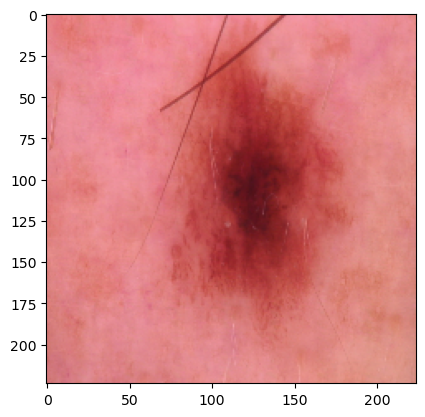

In [10]:
fig = plt.figure()
plt.imshow(image_list[0])
plt.show()

## Process Metadata 

In [16]:
image_metadata =  os.path.join(filepath, "HAM10000_img/HAM10000_metadata.csv")
image_metadata = pd.read_csv(image_metadata)
print("Metadata shape", image_metadata.shape)
print(image_metadata.head())

Metadata shape (10015, 7)
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


## Convert Image to Pandas dataframe using image_id as key

In [19]:
#(10015, 450, 600, 3)
image_dataframe = pd.DataFrame({'image_id': name_list, 'data': list(image_list)})
print("Image dataframe", image_dataframe.head())

Image dataframe        image_id                                               data
0  ISIC_0024306  [[[0.8745098039215686, 0.5058823529411764, 0.4...
1  ISIC_0024307  [[[0.8431372549019608, 0.4823529411764706, 0.5...
2  ISIC_0024308  [[[0.9686274509803922, 0.6745098039215687, 0.7...
3  ISIC_0024309  [[[0.8235294117647058, 0.47843137254901963, 0....
4  ISIC_0024310  [[[0.27450980392156865, 0.13333333333333333, 0...


In [21]:
#Clear memory
name_list =[]
image_list =[]

## Compute Class Weights for Disproportionate classes

In [24]:
def compute_class_weights(data):
    #Weights
    temp = pd.Categorical(data)
    values = temp.value_counts()
    
    weight_list = []
    label_list = []
    for label in temp.categories:
        label_list.append(label)
        weight_list.append(len(data)/(7*values[label]))
        
    weighted = pd.DataFrame({'dx': label_list, 'weights':weight_list})
    return weighted

In [26]:
#We have a huge class imbalance, we must correct it by data augmenting all classes that aren't "nv"
weighted = compute_class_weights(image_metadata["dx"])
print(weighted)

      dx    weights
0  akiec   4.375273
1    bcc   2.783491
2    bkl   1.301833
3     df  12.440994
4    mel   1.285458
5     nv   0.213380
6   vasc  10.075453


## Merge Image Dataframe and Metadata Dataframe

In [29]:
labels = image_metadata[["image_id", "dx"]]

#Merge dataframes
fin_dataframe = pd.merge(image_dataframe, labels)

#(Image_id, Image, Class)
print(fin_dataframe.head())

       image_id                                               data   dx
0  ISIC_0024306  [[[0.8745098039215686, 0.5058823529411764, 0.4...   nv
1  ISIC_0024307  [[[0.8431372549019608, 0.4823529411764706, 0.5...   nv
2  ISIC_0024308  [[[0.9686274509803922, 0.6745098039215687, 0.7...   nv
3  ISIC_0024309  [[[0.8235294117647058, 0.47843137254901963, 0....   nv
4  ISIC_0024310  [[[0.27450980392156865, 0.13333333333333333, 0...  mel


## 80:20 Split Into Training and Validation

In [32]:
#80:20 Split
train_dataset, valid_dataset = train_test_split(fin_dataframe,  test_size = .2, random_state = 5, stratify = fin_dataframe["dx"])
train_dataset, valid_dataset = train_dataset.reset_index(drop=True), valid_dataset.reset_index(drop=True)
print(train_dataset.shape, valid_dataset.shape)
print(train_dataset["dx"].value_counts())
print(valid_dataset["dx"].value_counts())


(8012, 3) (2003, 3)
dx
nv       5364
mel       890
bkl       879
bcc       411
akiec     262
vasc      114
df         92
Name: count, dtype: int64
dx
nv       1341
mel       223
bkl       220
bcc       103
akiec      65
vasc       28
df         23
Name: count, dtype: int64


## Data Augmentation and Oversampling for Class Imbalance

In [35]:
oversample = {"mel": 5, "bkl":5, "bcc":12, "akiec":20, "vasc": 45, "df":55, "nv":0}

for i in range(len(train_dataset)):
    for j in range(oversample[train_dataset.at[i, "dx"]]):
        #Oversampling until class samples are similar in size
        train_dataset = pd.concat([train_dataset, train_dataset.iloc[[i]]], ignore_index = True)


In [36]:
#Counts of each duplicate
print(train_dataset.shape)
print(train_dataset["dx"].value_counts())

(37219, 3)
dx
akiec    5502
nv       5364
bcc      5343
mel      5340
bkl      5274
vasc     5244
df       5152
Name: count, dtype: int64


## Recompute Class Weights

In [38]:
#Compute Weights
weighted = compute_class_weights(train_dataset["dx"])
print(weighted)

      dx   weights
0  akiec  0.966376
1    bcc  0.995134
2    bkl  1.008153
3     df  1.032026
4    mel  0.995693
5     nv  0.991238
6   vasc  1.013921


In [42]:
train_dataset = pd.merge(train_dataset, weighted)
valid_dataset = pd.merge(valid_dataset, weighted)

## Shuffle Data

In [45]:
#Shuffle Data
train_dataset = train_dataset.sample(frac=1,random_state=5,replace=False).reset_index(drop=True)
print(train_dataset.head())

       image_id                                               data   dx  \
0  ISIC_0030319  [[[0.5647058823529412, 0.4392156862745098, 0.4...  bkl   
1  ISIC_0032287  [[[0.5647058823529412, 0.4549019607843137, 0.4...  mel   
2  ISIC_0033808  [[[0.6941176470588235, 0.6274509803921569, 0.7...   df   
3  ISIC_0029170  [[[0.7058823529411765, 0.5372549019607843, 0.5...  mel   
4  ISIC_0027613  [[[0.10980392156862745, 0.06666666666666667, 0...   df   

    weights  
0  1.008153  
1  0.995693  
2  1.032026  
3  0.995693  
4  1.032026  


## Extract Unique Class Weights for training

In [48]:
all_weights = torch.tensor(weighted["weights"], dtype=torch.float32)
print("All weights:", all_weights)

All weights: tensor([0.9664, 0.9951, 1.0082, 1.0320, 0.9957, 0.9912, 1.0139])


# Load into Dataloaders

In [51]:
class Melanoma_Dataset(Dataset):
    def __init__(self, df, target, transform = None):
        super(Melanoma_Dataset, self).__init__()
        self.df = df
        self.target = target
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        '''Return rows of panda columns'''
        cur_img = self.df.loc[idx, "data"]

        temp_list = np.zeros(7)
        temp_list[int(self.target[idx])] = 1
        cur_target = torch.tensor(temp_list, dtype=torch.float32)

        cur_weights = self.df.loc[idx, "weights"]
        cur_weights = torch.tensor(cur_weights.tolist(), dtype=torch.float32)

        if(self.transform):
            cur_img = self.transform(Image.fromarray((cur_img*255.0).astype(np.uint8)))/255.0
        else:
            cur_img = torch.tensor(cur_img.tolist(), dtype=torch.float32)
            

        return cur_img, cur_target, cur_weights

In [53]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(), 
    transforms.Normalize(norm_mean, norm_std)
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

## 80:20 Datasplit

In [56]:
#80:20 datasplit with training_data oversampled and augmented
print(train_dataset.shape, valid_dataset.shape)

train_dataset = Melanoma_Dataset(train_dataset, pd.Categorical(train_dataset["dx"]).codes, train_transform)
valid_dataset = Melanoma_Dataset(valid_dataset, pd.Categorical(valid_dataset["dx"]).codes, val_transform)

(37219, 4) (2003, 4)


## Dataloader

In [59]:
train_dataset = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
valid_dataset = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)
X,Y,W = next(iter(train_dataset))
print(X.shape, Y.shape, W.shape)

print(len(valid_dataset))
X,Y, W = next(iter(valid_dataset))
print(X.shape, Y.shape, W.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32, 7]) torch.Size([32])
63
torch.Size([32, 3, 224, 224]) torch.Size([32, 7]) torch.Size([32])


## Accuracy Functions

In [62]:
def weight_accuracy(predicted_y, true_y, weight):
    pred_y, tar_y, w = np.array(predicted_y), np.array(true_y), np.array(weight)
    return np.sum((pred_y == tar_y) * w.reshape(w.size)) / np.sum(w)

def num_accuracy(predicted_y, true_y):
    pred_y, tar_y = np.array(predicted_y), np.array(true_y)
    return np.sum((pred_y == tar_y)) / len(pred_y)

# Resnet50 Model

In [67]:
resnet50 = torchvision.models.resnet50(weights='DEFAULT')
resnet50.fc = nn.Linear(resnet50.fc.in_features, 7)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(resnet50.parameters(), lr=0.0001)

for name, parameter in resnet50.named_parameters():
    if(parameter.requires_grad):
        print("not frozen", name)
    else:
        print("frozen", name)

conf_list = []
precise_list = []
recall_list = []
f1_list = []

y_pred_list = []
y_target_list = []

valid_acc_list = []
train_acc_list = []


not frozen conv1.weight
not frozen bn1.weight
not frozen bn1.bias
not frozen layer1.0.conv1.weight
not frozen layer1.0.bn1.weight
not frozen layer1.0.bn1.bias
not frozen layer1.0.conv2.weight
not frozen layer1.0.bn2.weight
not frozen layer1.0.bn2.bias
not frozen layer1.0.conv3.weight
not frozen layer1.0.bn3.weight
not frozen layer1.0.bn3.bias
not frozen layer1.0.downsample.0.weight
not frozen layer1.0.downsample.1.weight
not frozen layer1.0.downsample.1.bias
not frozen layer1.1.conv1.weight
not frozen layer1.1.bn1.weight
not frozen layer1.1.bn1.bias
not frozen layer1.1.conv2.weight
not frozen layer1.1.bn2.weight
not frozen layer1.1.bn2.bias
not frozen layer1.1.conv3.weight
not frozen layer1.1.bn3.weight
not frozen layer1.1.bn3.bias
not frozen layer1.2.conv1.weight
not frozen layer1.2.bn1.weight
not frozen layer1.2.bn1.bias
not frozen layer1.2.conv2.weight
not frozen layer1.2.bn2.weight
not frozen layer1.2.bn2.bias
not frozen layer1.2.conv3.weight
not frozen layer1.2.bn3.weight
not froz

In [69]:
num_epochs = 10
total_step = len(train_dataset)
for epoch in range(num_epochs):
    resnet50.train()
    train_correct, train_total = 0, 0
    for i, (X, Y, W) in enumerate(train_dataset):
        criterion.weight = all_weights
        # Forward pass
        output = resnet50(X)
        loss = criterion(output, Y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, true_Y = torch.max(Y, 1)
        _, predicted = torch.max(output, 1)
        train_correct += (predicted == true_Y).sum().item()
        train_total += len(true_Y)

        if(i%100 == 0):
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Training Accuracy [{}]'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item(), train_correct/train_total))
    
    print ('Training Accuracy [{}]'
                   .format(train_correct/train_total))
    train_acc_list.append(train_correct/train_total)
    
    y_pred_list = []
    y_target_list = []
    resnet50.eval()
    with torch.no_grad():
        for i, (X, Y, W) in enumerate(valid_dataset):
            output = resnet50(X)

            y_pred_list = np.concatenate((y_pred_list, (np.argmax(np.array(output.cpu().data), axis = 1))), axis = 0)

            y_target_list = np.concatenate((y_target_list, (np.argmax(np.array(Y.cpu().data), axis=1))), axis= 0)

            # y_weight_list = np.concatenate((y_weight_list, np.array(W.cpu().data)), axis=0)



    conf_list.append(confusion_matrix(y_pred_list,y_target_list))
    precise_list.append(precision_score(y_pred_list,y_target_list, average="weighted"))
    recall_list.append(recall_score(y_pred_list,y_target_list, average="weighted"))
    f1_list.append(f1_score(y_pred_list,y_target_list, average="weighted"))
    valid_acc_list.append(num_accuracy(y_pred_list,y_target_list))

    print("Validation Accuracy:", num_accuracy(y_pred_list,y_target_list))


Epoch [1/10], Step [1/1164], Loss: 1.9088, Training Accuracy [0.15625]
Epoch [1/10], Step [101/1164], Loss: 0.6580, Training Accuracy [0.5213490099009901]
Epoch [1/10], Step [201/1164], Loss: 0.6572, Training Accuracy [0.6218905472636815]
Epoch [1/10], Step [301/1164], Loss: 0.7397, Training Accuracy [0.6729651162790697]
Epoch [1/10], Step [401/1164], Loss: 0.6223, Training Accuracy [0.7051122194513716]
Epoch [1/10], Step [501/1164], Loss: 0.1942, Training Accuracy [0.7303517964071856]
Epoch [1/10], Step [601/1164], Loss: 0.2117, Training Accuracy [0.7483361064891847]
Epoch [1/10], Step [701/1164], Loss: 0.6120, Training Accuracy [0.7615014265335235]
Epoch [1/10], Step [801/1164], Loss: 0.5868, Training Accuracy [0.7736033083645443]
Epoch [1/10], Step [901/1164], Loss: 0.3054, Training Accuracy [0.7846143174250833]
Epoch [1/10], Step [1001/1164], Loss: 0.3469, Training Accuracy [0.7937687312687313]
Epoch [1/10], Step [1101/1164], Loss: 0.3495, Training Accuracy [0.8023103996366939]
Tra

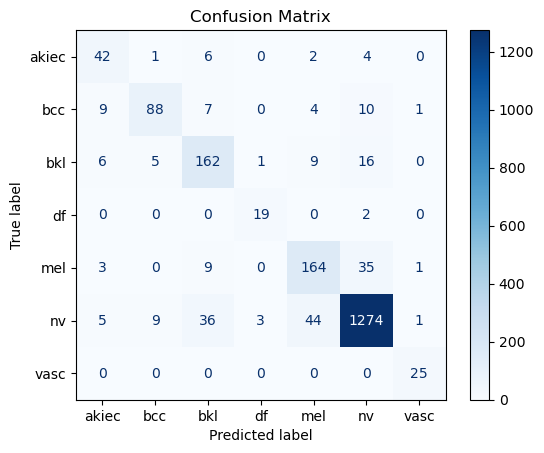

In [121]:
labels = ["akiec", "bcc", "bkl", "df", "mel", "nv", "vasc"] 
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_pred_list,y_target_list), display_labels = labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [123]:
print(classification_report(y_pred_list, y_target_list, target_names = labels))

              precision    recall  f1-score   support

       akiec       0.65      0.76      0.70        55
         bcc       0.85      0.74      0.79       119
         bkl       0.74      0.81      0.77       199
          df       0.83      0.90      0.86        21
         mel       0.74      0.77      0.75       212
          nv       0.95      0.93      0.94      1372
        vasc       0.89      1.00      0.94        25

    accuracy                           0.89      2003
   macro avg       0.81      0.85      0.82      2003
weighted avg       0.89      0.89      0.89      2003



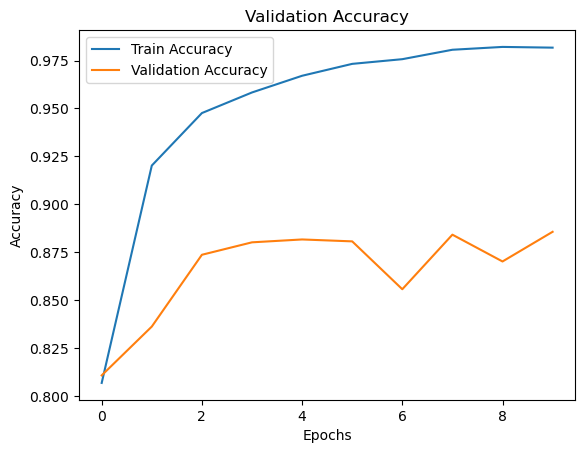

In [113]:
fig = plt.figure()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.plot([i for i in range(10)], train_acc_list, label = "Train Accuracy")
plt.plot([i for i in range(10)], valid_acc_list, label = "Validation Accuracy")
plt.legend()
plt.show()